In [9]:
import os
import pandas as pd 
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

os.environ['WANDB_API_KEY'] = # TODO: you wandb api key

In [17]:
def get_runs(filters, proj='struct_mlp', tune_on='test', avg_seeds=True):
    api = wandb.Api()
    runs = api.runs(proj, filters=filters, order='-created_at')
    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_dict = {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
    }
    runs_df = pd.DataFrame(runs_dict)


    runs_df = runs_df[runs_df['summary'].apply(lambda x: x != {})]
    keys = ['model', 'optimizer', 'width', 'depth', 'struct', 'layers', 'rank_frac', 'tt_rank', 'num_blocks', 'cola_params', 'cola_flops', 'lr', 'seed']
    
    for key in keys:
        if key == 'struct':
            # If 'struct' is None, use the value from 'cola_strategy'
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else x.get('cola_strategy', None))
        elif key == 'layers':
            # If 'layers' is None, default to 'all_but_last'
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 'all_but_last')
        elif key == 'lr':
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x and x[key] is not None else 5e-5)
        else:
            # For other keys, just extract the value if it exists
            runs_df[key] = runs_df['config'].apply(lambda x: x[key] if key in x else -1)
    runs_df['first_layer_flops'] = runs_df['width'] * (32 * 32 * 3)
    # rank_frac == 1 if struct is not low_rank
    runs_df.loc[~runs_df['struct'].isin(['low_rank', 'low_rank_and_kron', 'sum']), 'rank_frac'] = 1
        
    for key in ['test_acc', 'train_acc', 'train_acc_avg', 'train_loss_avg', 'epoch', 'test_loss', 'val_loss', 'val_acc', '_runtime', 'dh_avg_2']:
        runs_df[key] = runs_df['summary'].apply(lambda x: x[key] if key in x else -1)
    runs_df['runtime'] = runs_df['_runtime'].apply(lambda x: x / 60) # convert to minutes
    runs_df['test_error'] = 100 - runs_df['test_acc']
    runs_df['val_error'] = 100 - runs_df['val_acc']
    runs_df['train_error'] = 100 - runs_df['train_acc']
    runs_df['train_error_avg'] = 100 - runs_df['train_acc_avg']
    
    not_nans = ['width', 'depth', 'test_acc', 'train_acc', 'epoch', 'test_loss']
    runs_df = runs_df[runs_df[not_nans].notna().all(axis=1)]
    # replace nans with None
    runs_df = runs_df.fillna(value='None')

    # delete name summary and config
    runs_df = runs_df.drop(columns=['summary', 'config', 'name'])
    runs_df.loc[(runs_df['struct'] == 'none'), 'layers'] = 'none'

    # Everything else being equal, only keep the best run
    if tune_on is not None:
        if 'loss' in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]
        
    # average over seeds
    if avg_seeds:
        keys = [k for k in keys if k != 'seed']
        numeric_cols = runs_df.select_dtypes(include=[np.number]).columns.tolist()
        agg_dict = {col: 'mean' for col in numeric_cols}
        agg_dict.update({col: 'first' for col in keys})
        
        runs_df = runs_df.groupby(keys).agg(agg_dict).reset_index(drop=True)
    # Tune LR
    if tune_on is not None:
        # remove lr
        keys = [k for k in keys if k != 'lr']
        if 'loss' in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]
    return runs_df

In [13]:
struct_names = {
    'none': 'Dense',
    'dense': 'Dense',
    'tt': 'TT',
    'btt': 'BTT',
    'kron': 'Kron',
    'monarch': 'Monarch',
    'low_rank': 'Low Rank',
}

/tmp/ipykernel_2416404/1842326425.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2416404/1842326425.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=hue_order, y=slopes, palette=pallette)
/tmp/ipykernel_2416404/1842326425.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2416404/1842326425.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=hue_order, y=slopes, palette=pallette)


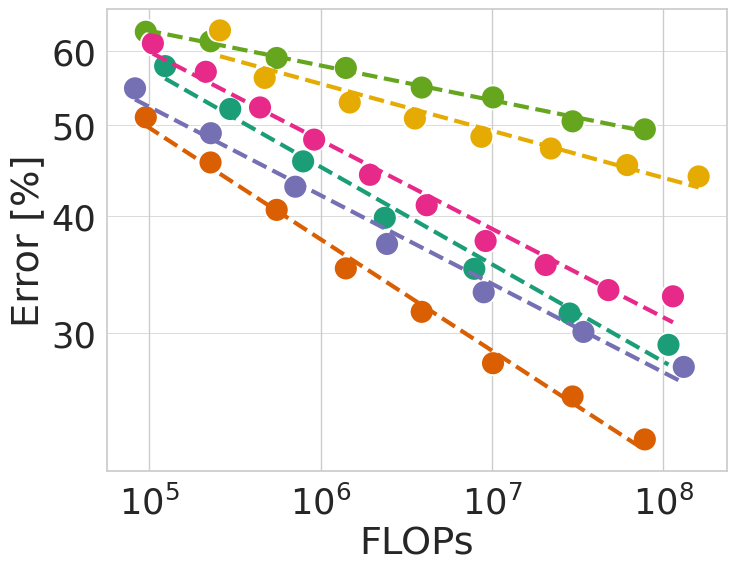

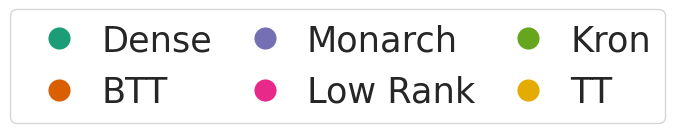

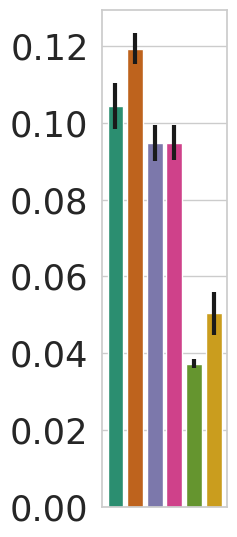

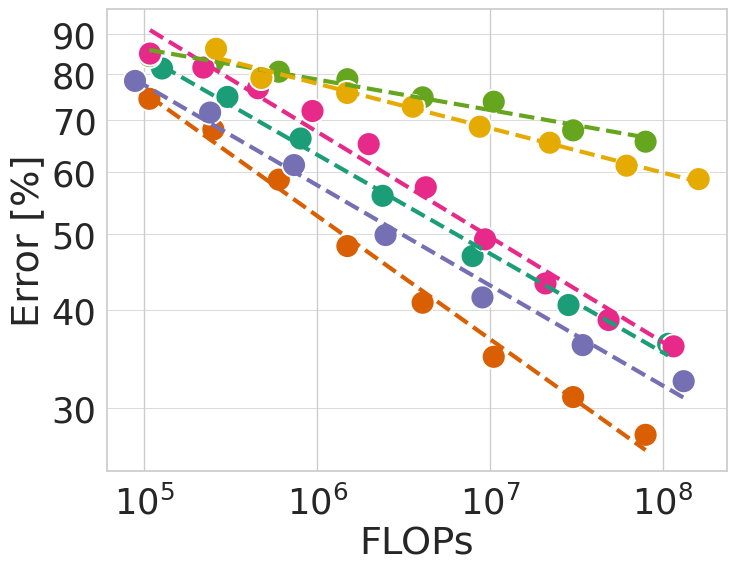

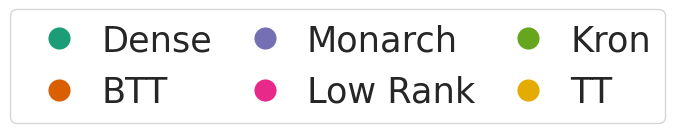

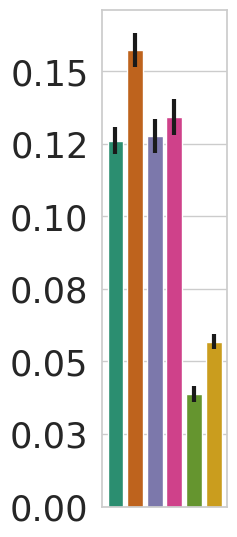

In [18]:
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set(style="whitegrid", font_scale=2.3, rc={"lines.linewidth": 3.0})

xname = 'cola_flops'
xlabel = 'FLOPs'

yname = 'train_error_avg'
ylabel = 'Error [%]'


fit = True

for ds in ['cifar10', 'cifar100']:
    filters = {
        "state": "finished",
        "config.dataset": {"$eq": ds},
        "config.model": {"$eq": 'MLP'},
        "config.depth": 3,
        "config.epochs": 500,
        "config.mixup": 0.8,
        "config.lr": 3e-3,
        "config.use_wrong_mult": False,
        "config.shuffle_pixels": True,
    }

    runs = get_runs(filters, proj=f'ap-team/mlp_{ds}', tune_on='train_acc_avg', avg_seeds=True)
    runs = runs[runs['struct'].isin(['none', 'btt', 'kron', 'tt', 'monarch', 'low_rank'])] 
    
    runs = runs[~(runs['struct'] == 'low_rank') | (runs['layers'] == 'intermediate')]
    runs['struct'] = runs['struct'].apply(lambda x: struct_names[x])
    
    # same struct and cola_flops, keep lowest error
    idx = runs.groupby(['struct', 'cola_flops'])['train_error_avg'].idxmin()
    runs = runs.loc[idx]
    

    # log log scale, scatter plot
    hue_order = ['Dense', 'BTT', 'Monarch', 'Low Rank', 'Kron', 'TT'] 
    runs = runs[runs['struct'].isin(hue_order)]
    pallette = sns.color_palette("Dark2", n_colors=len(hue_order))
    

    plt.figure(dpi=100, figsize=(8, 6))
    if 'train' in yname:
        ax = sns.scatterplot(data=runs, x=xname, y=yname, hue='struct', markers=True, hue_order=hue_order, s=300, palette=pallette)
    else:
        ax = sns.lineplot(data=runs, x=xname, y=yname, hue='struct', markers=True, palette=pallette, hue_order=hue_order, marker='o', markersize=18, linewidth=3)
    if fit:
        # fit a line on the log log scale, for each struct
        slopes = []
        halfwidths = []
        for struct, color in zip(hue_order, pallette):
            struct_runs = runs[runs['struct'] == struct]
            x = np.log(struct_runs[xname])
            y = np.log(struct_runs[yname])
            m, b, r_value, p_value, std_err = stats.linregress(x,y)
            slope_conf_interval = std_err
            slopes.append(-m)
            halfwidths.append(slope_conf_interval)
            plt.plot(struct_runs[xname], np.exp(m * x + b), color=color, linestyle='--', linewidth=3, alpha=1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xscale('log')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

    ax.grid(which='minor', axis='y', linestyle='-', linewidth=0.5)
    handles, labels = ax.get_legend_handles_labels()
    # remove legend
    ax.get_legend().remove()
    if yname == 'train_error_avg':
        plt.savefig(f'mlp_{ds}.pdf', bbox_inches='tight')
    else:
        plt.savefig(f'mlp_{ds}_test.pdf', bbox_inches='tight')

    # legend as a separate figure
    legend_fig = plt.figure(figsize=(8, 1))  # Adjuxst size as needed
    ax_legend = legend_fig.add_subplot(111)
    ax_legend.legend(handles, labels, loc='center', ncol=len(labels)//2, columnspacing=0.5, handletextpad=0.2)
    ax_legend.axis('off') 
    plt.tight_layout()
    plt.savefig(f'mlp_{ds}_legend.pdf', bbox_inches='tight')
    # barplot for slopes
    if fit:
        plt.figure(dpi=100, figsize=(3, 6))
        ax = sns.barplot(x=hue_order, y=slopes, palette=pallette)
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=halfwidths, fmt="none", c="k")
        plt.xticks(rotation=45)
        plt.xticks([], [])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        plt.tight_layout()
        plt.savefig(f'mlp_{ds}_slopes.pdf', bbox_inches='tight')

/tmp/ipykernel_2416404/3643720473.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2416404/3643720473.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


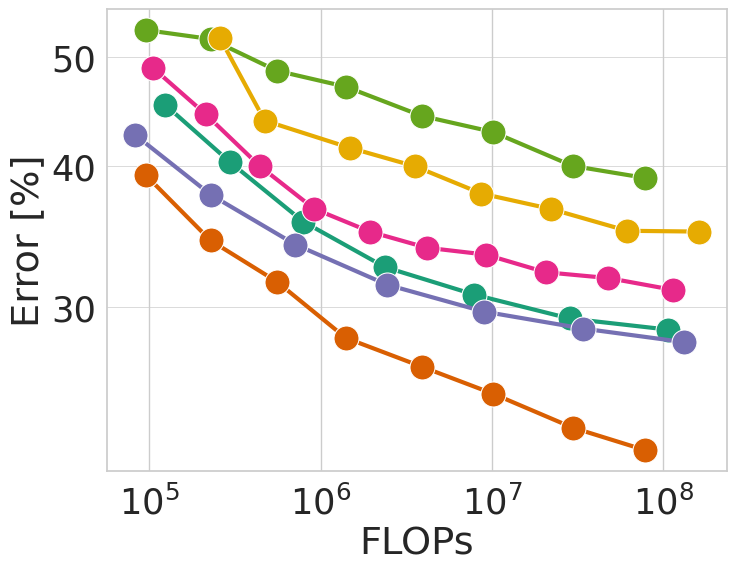

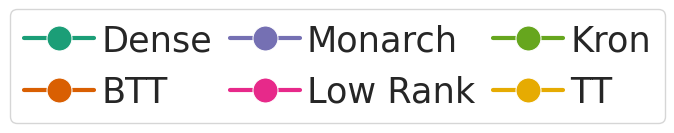

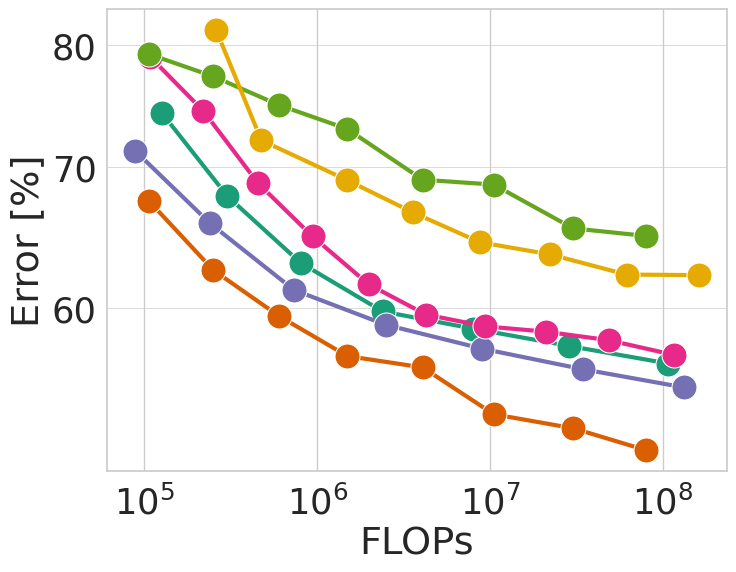

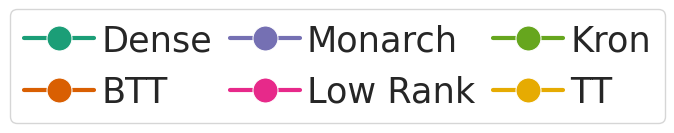

In [8]:
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set(style="whitegrid", font_scale=2.3, rc={"lines.linewidth": 3.0})

xname = 'cola_flops'
xlabel = 'FLOPs'

yname = 'test_error'
ylabel = 'Error [%]'


fit = False

for ds in ['cifar10', 'cifar100']:
    filters = {
        "state": "finished",
        "config.dataset": {"$eq": ds},
        "config.model": {"$eq": 'MLP'},
        "config.depth": 3,
        "config.epochs": 500,
        "config.mixup": 0.8,
        "config.lr": 3e-3,
        "config.use_wrong_mult": False,
        "config.shuffle_pixels": True,
    }

    runs = get_runs(filters, proj=f'ap-team/mlp_{ds}', tune_on='train_acc_avg', avg_seeds=True)
    runs = runs[runs['struct'].isin(['none', 'btt', 'kron', 'tt', 'monarch', 'low_rank'])] 
    
    runs = runs[~(runs['struct'] == 'low_rank') | (runs['layers'] == 'intermediate')]
    runs['struct'] = runs['struct'].apply(lambda x: struct_names[x])
    
    # same struct and cola_flops, keep lowest error
    idx = runs.groupby(['struct', 'cola_flops'])['train_error_avg'].idxmin()
    runs = runs.loc[idx]

    # log log scale, scatter plot
    hue_order = ['Dense', 'BTT', 'Monarch', 'Low Rank', 'Kron', 'TT'] 
    runs = runs[runs['struct'].isin(hue_order)]
    pallette = sns.color_palette("Dark2", n_colors=len(hue_order))
    

    plt.figure(dpi=100, figsize=(8, 6))
    if 'train' in yname:
        ax = sns.scatterplot(data=runs, x=xname, y=yname, hue='struct', markers=True, hue_order=hue_order, s=300, palette=pallette)
    else:
        ax = sns.lineplot(data=runs, x=xname, y=yname, hue='struct', markers=True, palette=pallette, hue_order=hue_order, marker='o', markersize=18, linewidth=3)
    if fit:
        # fit a line on the log log scale, for each struct
        slopes = []
        halfwidths = []
        for struct, color in zip(hue_order, pallette):
            struct_runs = runs[runs['struct'] == struct]
            x = np.log(struct_runs[xname])
            y = np.log(struct_runs[yname])
            m, b, r_value, p_value, std_err = stats.linregress(x,y)
            slope_conf_interval = std_err
            slopes.append(-m)
            halfwidths.append(slope_conf_interval)
            plt.plot(struct_runs[xname], np.exp(m * x + b), color=color, linestyle='--', linewidth=3, alpha=1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xscale('log')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

    ax.grid(which='minor', axis='y', linestyle='-', linewidth=0.5)
    handles, labels = ax.get_legend_handles_labels()
    # remove legend
    ax.get_legend().remove()
    if yname == 'train_error_avg':
        plt.savefig(f'mlp_{ds}.pdf', bbox_inches='tight')
    else:
        plt.savefig(f'mlp_{ds}_test.pdf', bbox_inches='tight')

    # legend as a separate figure
    legend_fig = plt.figure(figsize=(8, 1))  # Adjuxst size as needed
    ax_legend = legend_fig.add_subplot(111)
    ax_legend.legend(handles, labels, loc='center', ncol=len(labels)//2, columnspacing=0.5, handletextpad=0.2)
    ax_legend.axis('off') 
    plt.tight_layout()
    plt.savefig(f'mlp_{ds}_legend.pdf', bbox_inches='tight')
    # barplot for slopes
    if fit:
        plt.figure(dpi=100, figsize=(3, 6))
        ax = sns.barplot(x=hue_order, y=slopes, palette=pallette)
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=halfwidths, fmt="none", c="k")
        plt.xticks(rotation=45)
        plt.xticks([], [])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        plt.tight_layout()
        plt.savefig(f'mlp_{ds}_slopes.pdf', bbox_inches='tight')